# Convlution Autoencoder
- Prediction
- Save image id and predicted crop size for each test data
- Crop test images

In [1]:
import os, random, time
import numpy as np
import pandas as pd
import nibabel as nib
import cv2
import matplotlib.pyplot as plt

# Pytorch functions
import torch
# Neural network layers
import torch.nn as nn
import torch.nn.functional as F
# Optimizer
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
# Torchvision library
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# For results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from torchsummary import summary

from utilities import *

In [2]:
to_predict = False

All learning rates are 1e-2

In [3]:
CA_Flair = pd.read_csv('./results/CA_Flair.csv')
CA_T1 = pd.read_csv('./results/CA_T1.csv')
CA_T1CE = pd.read_csv('./results/CA_T1CE.csv')
CA_T2 = pd.read_csv('./results/CA_T2.csv')

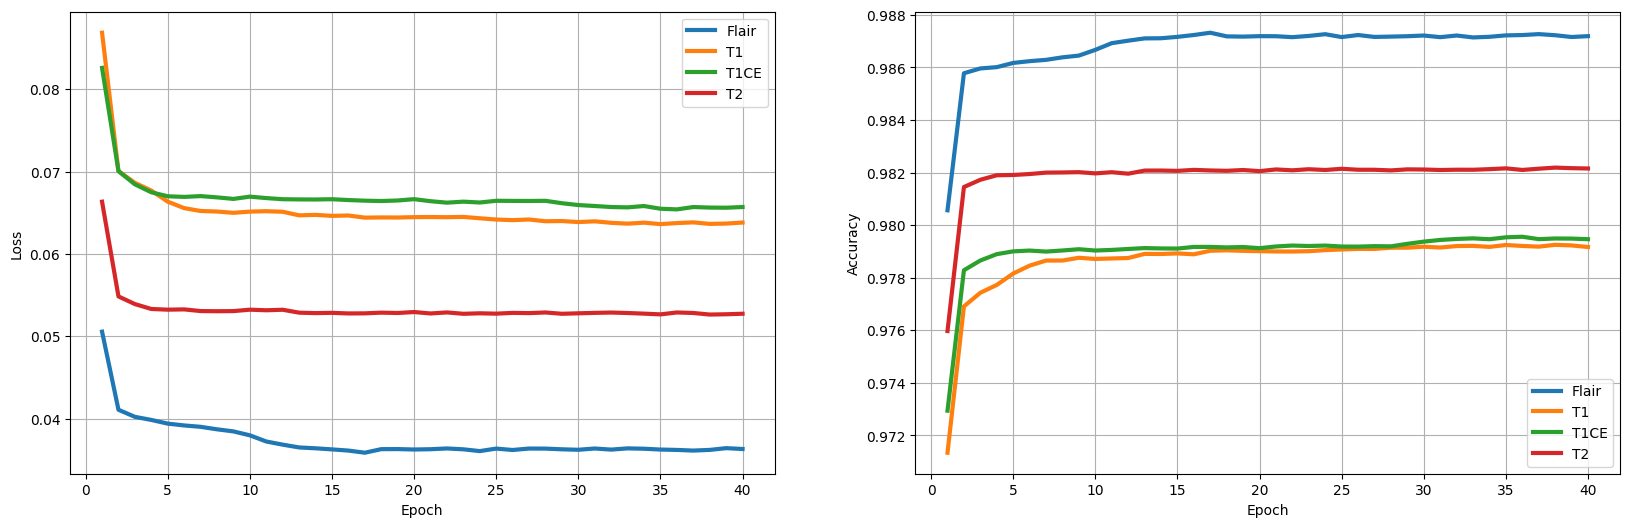

In [4]:
# Plot results
plt.figure(figsize=(20, 6))
_ = plt.subplot(1,2,1)
plt.plot(np.arange(len(CA_Flair['Train Loss']))+1, CA_Flair['Train Loss'], linewidth=3)
plt.plot(np.arange(len(CA_T1['Train Loss']))+1, CA_T1['Train Loss'], linewidth=3)
plt.plot(np.arange(len(CA_T1CE['Train Loss']))+1, CA_T1CE['Train Loss'], linewidth=3)
plt.plot(np.arange(len(CA_T2['Train Loss']))+1, CA_T2['Train Loss'], linewidth=3)
_ = plt.legend(['Flair', 'T1', 'T1CE', 'T2'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

_ = plt.subplot(1,2,2)
plt.plot(np.arange(len(CA_Flair['Train Acc']))+1, CA_Flair['Train Acc'], linewidth=3)
plt.plot(np.arange(len(CA_T1['Train Acc']))+1, CA_T1['Train Acc'], linewidth=3)
plt.plot(np.arange(len(CA_T1CE['Train Acc']))+1, CA_T1CE['Train Acc'], linewidth=3)
plt.plot(np.arange(len(CA_T2['Train Acc']))+1, CA_T2['Train Acc'], linewidth=3)
_ = plt.legend(['Flair', 'T1', 'T1CE', 'T2'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

plt.show()

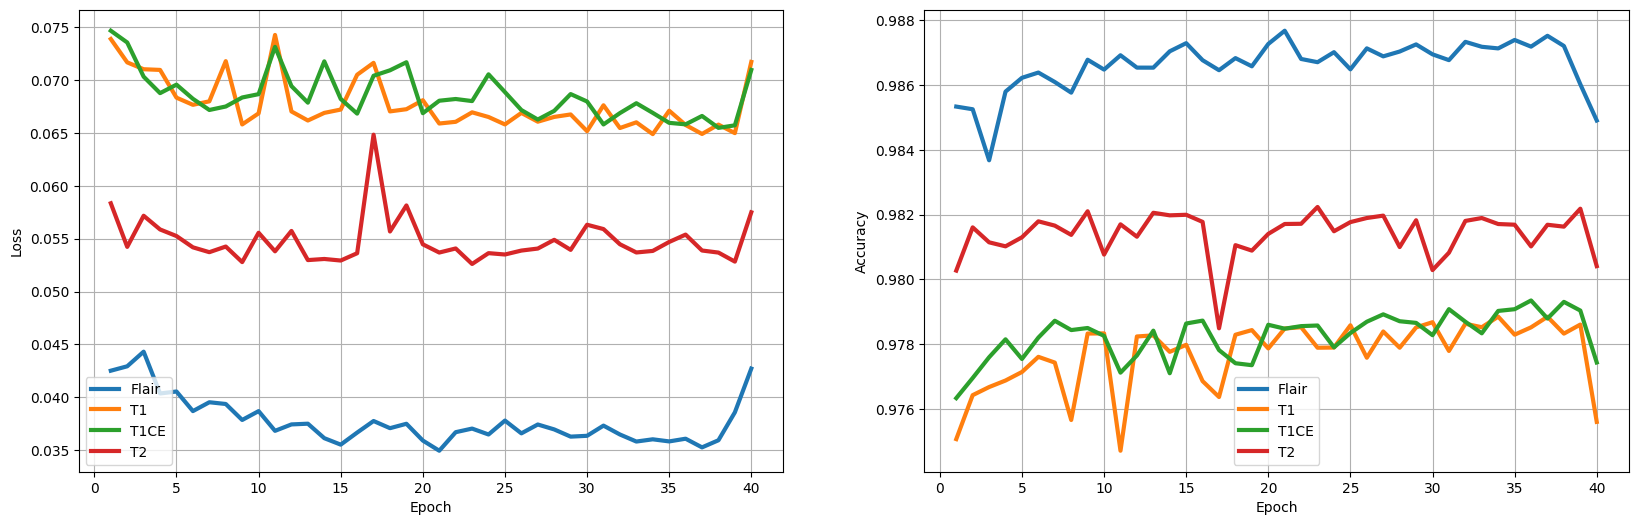

In [5]:
# Plot results
plt.figure(figsize=(20, 6))
_ = plt.subplot(1,2,1)
plt.plot(np.arange(len(CA_Flair['Valid Loss']))+1, CA_Flair['Valid Loss'], linewidth=3)
plt.plot(np.arange(len(CA_T1['Valid Loss']))+1, CA_T1['Valid Loss'], linewidth=3)
plt.plot(np.arange(len(CA_T1CE['Valid Loss']))+1, CA_T1CE['Valid Loss'], linewidth=3)
plt.plot(np.arange(len(CA_T2['Valid Loss']))+1, CA_T2['Valid Loss'], linewidth=3)
_ = plt.legend(['Flair', 'T1', 'T1CE', 'T2'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

_ = plt.subplot(1,2,2)
plt.plot(np.arange(len(CA_Flair['Valid Acc']))+1, CA_Flair['Valid Acc'], linewidth=3)
plt.plot(np.arange(len(CA_T1['Valid Acc']))+1, CA_T1['Valid Acc'], linewidth=3)
plt.plot(np.arange(len(CA_T1CE['Valid Acc']))+1, CA_T1CE['Valid Acc'], linewidth=3)
plt.plot(np.arange(len(CA_T2['Valid Acc']))+1, CA_T2['Valid Acc'], linewidth=3)
_ = plt.legend(['Flair', 'T1', 'T1CE', 'T2'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

plt.show()

In [6]:
best_model_CA_Flair = CA_Flair['Valid Loss'].idxmin()
best_model_CA_T1 = CA_T1['Valid Loss'].idxmin()
best_model_CA_T1CE = CA_T1CE['Valid Loss'].idxmin()
best_model_CA_T2 = CA_T2['Valid Loss'].idxmin()
pd.concat([CA_Flair.iloc[best_model_CA_Flair], CA_T1.iloc[best_model_CA_T1], CA_T1CE.iloc[best_model_CA_T1CE], CA_T2.iloc[best_model_CA_T2]], axis=1, keys=['Flair', 'T1', 'T1CE', 'T2'])

,Flair,T1,T1CE,T2
Train Loss,0.036287,0.063796,0.065626,0.052728
Train Acc,0.987186,0.979171,0.979490,0.982126
Valid Loss,0.034945,0.064895,0.065485,0.052609
Valid Acc,0.987678,0.978851,0.979308,0.982237


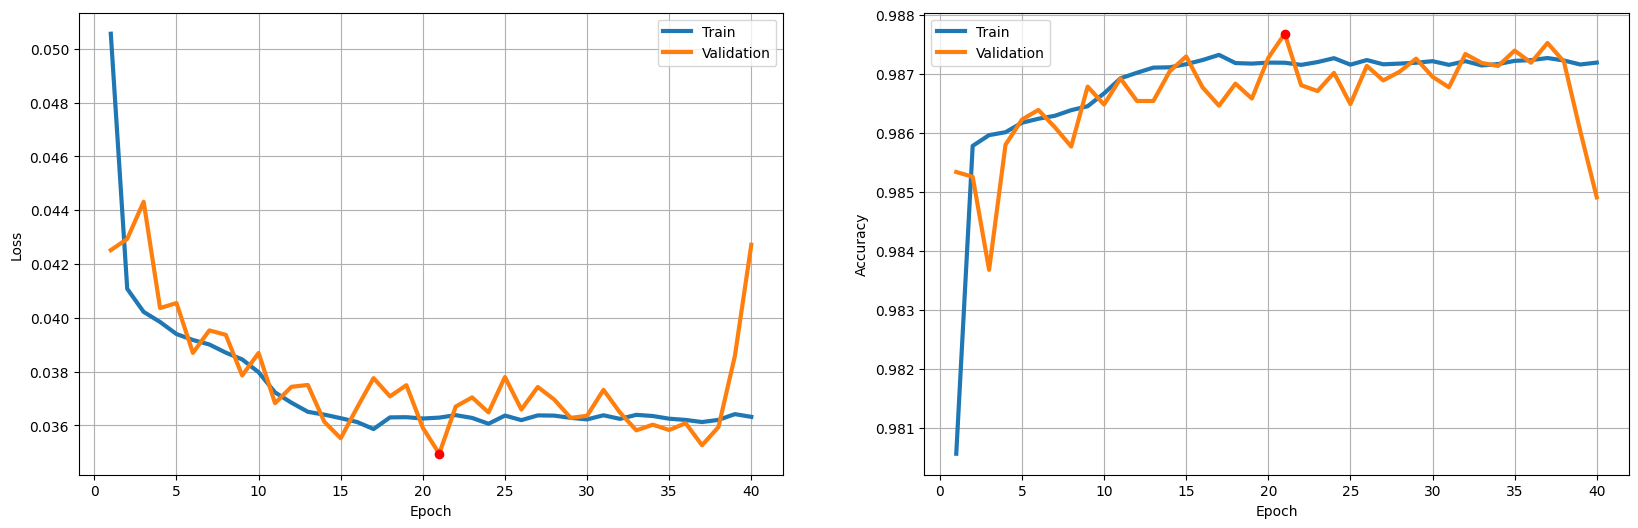

In [7]:
# Plot results
plt.figure(figsize=(20, 6))
_ = plt.subplot(1,2,1)
plt.plot(np.arange(len(CA_Flair['Train Loss']))+1, CA_Flair['Train Loss'], linewidth=3)
plt.plot(np.arange(len(CA_Flair['Valid Loss']))+1, CA_Flair['Valid Loss'], linewidth=3)
_ = plt.legend(['Train', 'Validation'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.plot(best_model_CA_Flair + 1, CA_Flair.iloc[best_model_CA_Flair]['Valid Loss'], "or")

_ = plt.subplot(1,2,2)
plt.plot(np.arange(len(CA_Flair['Train Acc']))+1, CA_Flair['Train Acc'], linewidth=3)
plt.plot(np.arange(len(CA_Flair['Valid Acc']))+1, CA_Flair['Valid Acc'], linewidth=3)
_ = plt.legend(['Train', 'Validation'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')
plt.plot(best_model_CA_Flair + 1, CA_Flair.iloc[best_model_CA_Flair]['Valid Acc'], "or")

plt.show()



So we use Flair according to validation loss.

# U-Net

- Apply any preprocessing for U-Net
- Amend custom dataset for the second model

All learning rates are 1e-4

In [8]:
UNet_Flair = pd.read_csv('./results/Unet_Flair.csv')
UNet_T1 = pd.read_csv('./results/UNet_T1.csv')
UNet_T1CE = pd.read_csv('./results/UNet_T1CE.csv')
UNet_T2 = pd.read_csv('./results/UNet_T2.csv')

In [9]:
UNet_Flair = UNet_Flair[:50]

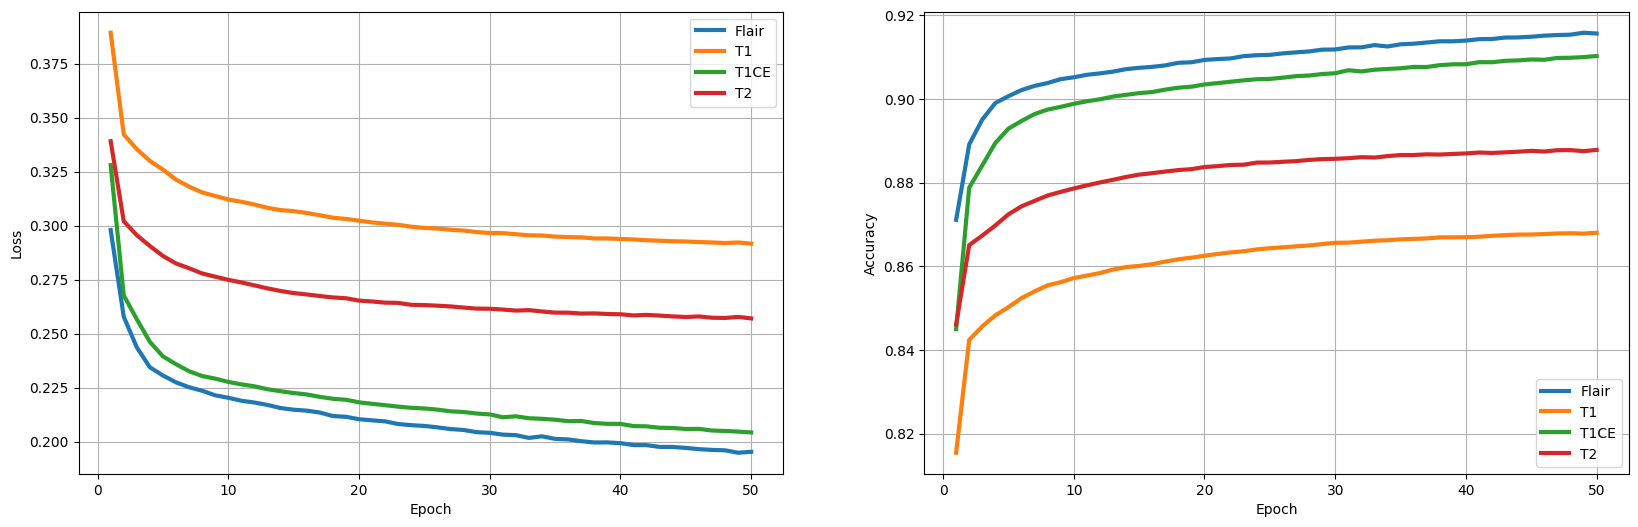

In [10]:
# Plot results
plt.figure(figsize=(20, 6))
_ = plt.subplot(1,2,1)
plt.plot(np.arange(len(UNet_Flair['Train Loss']))+1, UNet_Flair['Train Loss'], linewidth=3)
plt.plot(np.arange(len(UNet_T1['Train Loss']))+1, UNet_T1['Train Loss'], linewidth=3)
plt.plot(np.arange(len(UNet_T1CE['Train Loss']))+1, UNet_T1CE['Train Loss'], linewidth=3)
plt.plot(np.arange(len(UNet_T2['Train Loss']))+1, UNet_T2['Train Loss'], linewidth=3)
_ = plt.legend(['Flair', 'T1', 'T1CE', 'T2'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

_ = plt.subplot(1,2,2)
plt.plot(np.arange(len(UNet_Flair['Train Acc']))+1, UNet_Flair['Train Acc'], linewidth=3)
plt.plot(np.arange(len(UNet_T1['Train Acc']))+1, UNet_T1['Train Acc'], linewidth=3)
plt.plot(np.arange(len(UNet_T1CE['Train Acc']))+1, UNet_T1CE['Train Acc'], linewidth=3)
plt.plot(np.arange(len(UNet_T2['Train Acc']))+1, UNet_T2['Train Acc'], linewidth=3)
_ = plt.legend(['Flair', 'T1', 'T1CE', 'T2'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

plt.show()

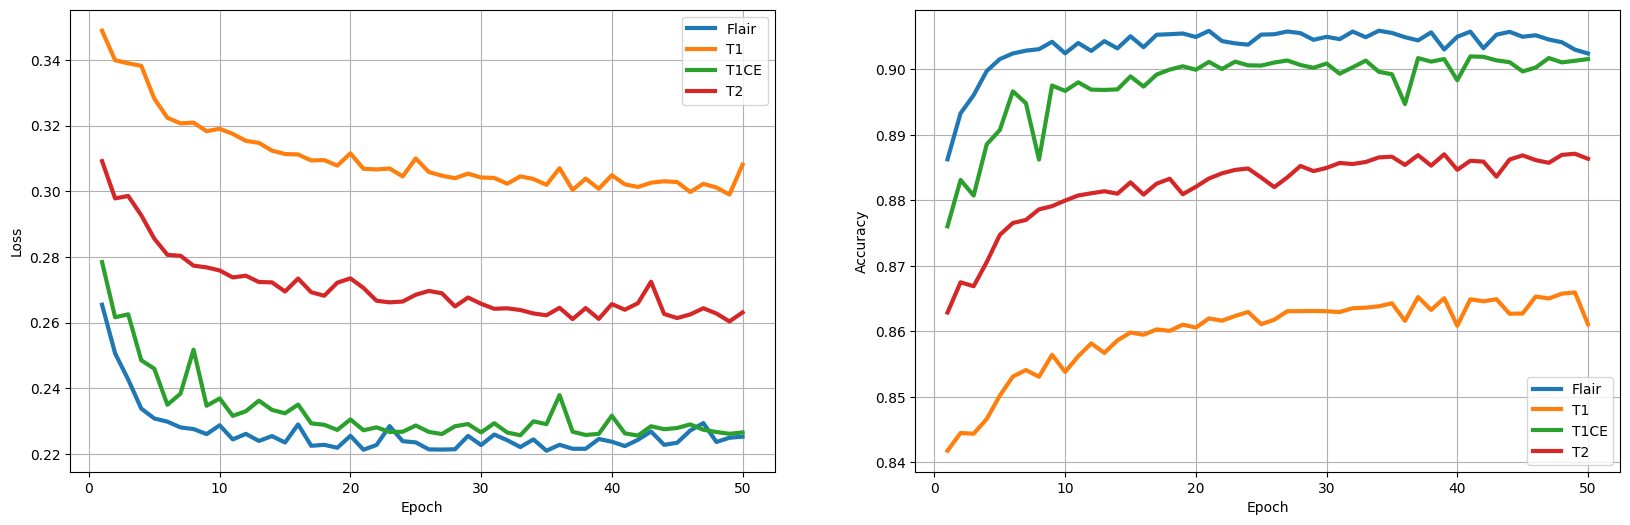

In [11]:
# Plot results
plt.figure(figsize=(20, 6))
_ = plt.subplot(1,2,1)
plt.plot(np.arange(len(UNet_Flair['Valid Loss']))+1, UNet_Flair['Valid Loss'], linewidth=3)
plt.plot(np.arange(len(UNet_T1['Valid Loss']))+1, UNet_T1['Valid Loss'], linewidth=3)
plt.plot(np.arange(len(UNet_T1CE['Valid Loss']))+1, UNet_T1CE['Valid Loss'], linewidth=3)
plt.plot(np.arange(len(UNet_T2['Valid Loss']))+1, UNet_T2['Valid Loss'], linewidth=3)
_ = plt.legend(['Flair', 'T1', 'T1CE', 'T2'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

_ = plt.subplot(1,2,2)
plt.plot(np.arange(len(UNet_Flair['Valid Acc']))+1, UNet_Flair['Valid Acc'], linewidth=3)
plt.plot(np.arange(len(UNet_T1['Valid Acc']))+1, UNet_T1['Valid Acc'], linewidth=3)
plt.plot(np.arange(len(UNet_T1CE['Valid Acc']))+1, UNet_T1CE['Valid Acc'], linewidth=3)
plt.plot(np.arange(len(UNet_T2['Valid Acc']))+1, UNet_T2['Valid Acc'], linewidth=3)
_ = plt.legend(['Flair', 'T1', 'T1CE', 'T2'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

plt.show()

In [12]:
best_model_UNet_Flair = UNet_Flair['Valid Loss'].idxmin()
best_model_UNet_T1 = UNet_T1['Valid Loss'].idxmin()
best_model_UNet_T1CE = UNet_T1CE['Valid Loss'].idxmin()
best_model_UNet_T2 = UNet_T2['Valid Loss'].idxmin()
pd.concat([UNet_Flair.iloc[best_model_UNet_Flair], UNet_T1.iloc[best_model_UNet_T1], UNet_T1CE.iloc[best_model_UNet_T1CE], UNet_T2.iloc[best_model_UNet_T2]], axis=1, keys=['Flair', 'T1', 'T1CE', 'T2'])

,Flair,T1,T1CE,T2
Train Loss,0.201302,0.292202,0.207101,0.257740
Train Acc,0.913042,0.867803,0.908756,0.887505
Valid Loss,0.220928,0.298987,0.225552,0.260324
Valid Acc,0.905577,0.865963,0.901929,0.887135


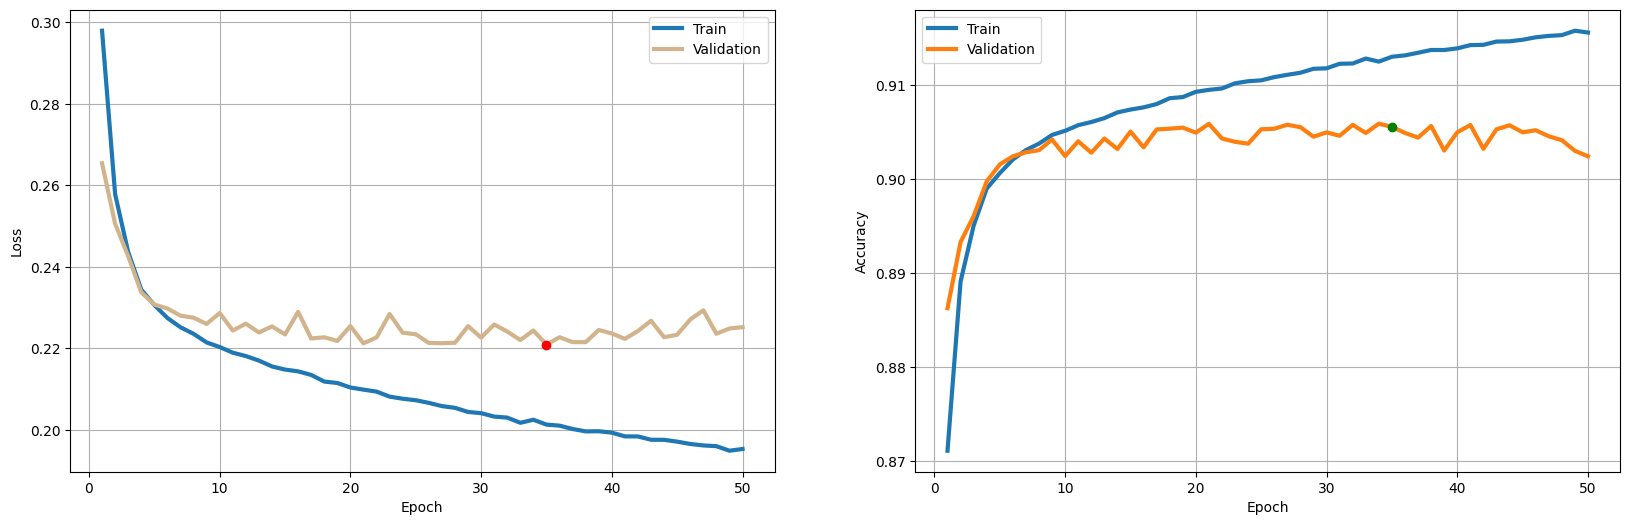

In [13]:
# Plot results
plt.figure(figsize=(20, 6))
_ = plt.subplot(1,2,1)
plt.plot(np.arange(len(UNet_Flair['Train Loss']))+1, UNet_Flair['Train Loss'], linewidth=3)
plt.plot(np.arange(len(UNet_Flair['Valid Loss']))+1, UNet_Flair['Valid Loss'], linewidth=3, color='tan')
_ = plt.legend(['Train', 'Validation'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.plot(best_model_UNet_Flair + 1, UNet_Flair.iloc[best_model_UNet_Flair]['Valid Loss'], "o", color='red')

_ = plt.subplot(1,2,2)
plt.plot(np.arange(len(UNet_Flair['Train Acc']))+1, UNet_Flair['Train Acc'], linewidth=3)
plt.plot(np.arange(len(UNet_Flair['Valid Acc']))+1, UNet_Flair['Valid Acc'], linewidth=3)
_ = plt.legend(['Train', 'Validation'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')
plt.plot(best_model_UNet_Flair + 1, UNet_Flair.iloc[best_model_UNet_Flair]['Valid Acc'], "o", color='green')

plt.show()

# Test entire model

In [2]:
N_EPOCHS = 40
batch_size = 64
scan_type = 'Flair'

# Device configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
   device = torch.device('mps')
else:
    device = torch.device('cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

def set_seed(seed, use_cuda = True, use_mps = False):
    """
    Set SEED for PyTorch reproducibility
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    if use_mps:
        torch.mps.manual_seed(seed)

SEED = 44

USE_SEED = True

if USE_SEED:
    set_seed(SEED, torch.cuda.is_available(), torch.backends.mps.is_available())
## Define Custom Dataset
class BraTSDataset(Dataset):
    def __init__(self, image_path = r'./BraTS/BraTS2021_Training_Data_2D', transform=None):
        'Initialisation'
        self.image_path = image_path
        self.folders_name = [folder for folder in os.listdir(self.image_path) if folder != '.DS_Store']
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.folders_name) * 155

    def __getitem__(self, index):
        'Generates one sample of data'

        # Determine the image index and the RGB layer
        image_idx = index // 155
        layer_idx = index % 155

        # Select sample
        file_name = self.folders_name[image_idx]
        
        path_img = os.path.join(self.image_path, file_name, scan_type.lower(), file_name + '_' + scan_type.lower() + '_' + str(layer_idx+1) + '.npy')
        image = np.load(path_img).astype(np.float32)

        path_label = os.path.join(self.image_path, file_name, 'seg', file_name + '_seg_' + str(layer_idx+1) + '.npy')
        label = np.load(path_label)
        
        if self.transform:
            image, label = self.transform([image, label])
        return image, label
class BinariseLabel(object):
    def __call__(self, sample):
        image, label = sample
        new_label = np.sign(label)
        return image, new_label

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, label = sample

        # numpy image: H x W x C
        # torch image: C x H x W
        # image = image.transpose((2, 0, 1))
        return torch.from_numpy(image), torch.from_numpy(label)
dataset = BraTSDataset(image_path = r'./BraTS/BraTS2021_Training_Data_2D',
                        transform=transforms.Compose([
                            BinariseLabel(),
                            ToTensor()
                        ]))
## Train Test Split
dataset_size = int(len(dataset)/155)
dataset_indices = list(range(dataset_size))

train_indices, test_indices = train_test_split(dataset_indices, test_size=0.1, random_state=SEED)
train_indices, val_indices = train_test_split(train_indices, test_size=0.22, random_state=SEED)

tmp_list = [[],[],[]]
for i, ind_list in enumerate([train_indices, val_indices, test_indices]):
    for ind in ind_list:
        for j in range(155):
            tmp_list[i].append(ind*155 + j)
train_indices, val_indices, test_indices = tmp_list

train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)
test_subset = Subset(dataset, test_indices)

# Create the subset DataLoader
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
# multiprocessing_context="forkserver", persistent_workers=True, num_workers = 4
## Define Convlutional Autoencoder Structure
class ConvAutoencoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      ## encoder layers ##
      # conv layer (depth from 1 --> 4), 3x3 kernels
      # Input 64 x 64
      nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding = 'same'), # 64 x 64
      nn.ReLU(),
      # pooling layer to reduce x-y dims by two; kernel and stride of 2
      nn.MaxPool2d(2), ## 32 x 32
      # conv layer (depth from 4 --> 8), 4x4 kernels
      nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding = 'same'), # 32 x 32
      nn.ReLU(),
      nn.MaxPool2d(2), # 16 x 16
      # conv layer (depth from 8 --> 12), 5x5 kernels
      nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, padding = 'same'), # ( 12 x ) 16 x 16
      nn.ReLU(),
      
      ## decoder layers ##
      # add transpose conv layers, with relu activation function
      nn.ConvTranspose2d(12, 6, kernel_size = 2, stride=2), # 32 x 32
      nn.ReLU(),
      nn.ConvTranspose2d(6, 1, kernel_size = 2, stride=2), # 64 x 64
      # output layer (with sigmoid for scaling from 0 to 1)
      # nn.Sigmoid()
    )
    
  def forward(self, x):
    x = x.view(int(np.prod(x.shape)/(64**2)), 1, 64, 64)
    x = self.features(x)
    # x = x.view(x.shape[0], -1)
    # x = torch.flatten(x, start_dim=1)
    return x
model = ConvAutoencoder().to(device)

print(f"The model has {count_parameters(model):,} trainable parameters.")
## Loss function and Optimisation Methods
# Loss
# criterion = nn.CrossEntropyLoss() # Softmax + CrossEntropy
# criterion = nn.BCELoss()
criterion = torch.nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

# Optim
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

model.load_state_dict(torch.load(f'./models/CA_{scan_type}.pt'))
model.to(device)

mps
The model has 1,531 trainable parameters.


ConvAutoencoder(
  (features): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): ConvTranspose2d(12, 6, kernel_size=(2, 2), stride=(2, 2))
    (9): ReLU()
    (10): ConvTranspose2d(6, 1, kernel_size=(2, 2), stride=(2, 2))
  )
)

In [3]:
to_predict = False

In [4]:
if to_predict:
    labels, preds = predict(model, test_dataloader, device)

In [5]:
if to_predict:
    test_loss, test_acc, test_batch_loss, test_batch_acc = model_testing(model, test_dataloader, criterion, device, model_name=f'./models/CA_{scan_type}.pt')

100.0 % loaded in this epoch for evaluation.

Test -- Loss: 0.036, Acc: 98.75 %


In [6]:
# To find the original file names
folders = [folder for folder in os.listdir(os.path.join('./BraTS', 'BraTS2021_Training_Data')) if folder != '.DS_Store']

def index_converter(index):
    return index // 155, 1 + index % 155 # image_idx, layer_idx

In [7]:
if to_predict:
    os.makedirs(os.path.join('./BraTS', f'CA_{scan_type}_Area'), exist_ok=True)

    pred_no_tumour = []
    pred_tumour = []
    for i in range(len(test_indices)):
        image_idx, layer_idx = index_converter(test_indices[i])
        image_idx = folders[image_idx]
        pred_label = preds[i]
        ## Find boundary box for the segmentation
        # Find the non-zero regions
        rows = torch.any(pred_label, axis=1)
        cols = torch.any(pred_label, axis=0)
        # Find the bounding box of the non-zero regions
        rows_indices = torch.where(rows)[0]
        cols_indices = torch.where(cols)[0]
        if len(rows_indices) == 0 or len(cols_indices) == 0:
            pred_no_tumour.append([str(image_idx).zfill(5), str(layer_idx)])
            continue
        pred_tumour.append([str(image_idx).zfill(5), str(layer_idx)])
        top_row = torch.min(rows_indices)
        bottom_row = torch.max(rows_indices)
        left_col = torch.min(cols_indices)
        right_col = torch.max(cols_indices)

        width = right_col - left_col
        height = bottom_row - top_row

        if width > height:
            top_row = top_row - np.floor((width - height) / 2)
            bottom_row = bottom_row + np.ceil((width - height) / 2)
            if top_row < 0:
                bottom_row = bottom_row - top_row
                top_row = 0
            if bottom_row > 63:
                top_row = top_row - (bottom_row - 63)
                bottom_row = 63
        else:
            left_col = left_col - np.floor((width - height) / 2)
            right_col = right_col + np.ceil((width - height) / 2)
            if left_col < 0:
                right_col = right_col - left_col
                left_col = 0
            if right_col > 63:
                left_col = left_col - (right_col - 63)
                right_col = 63
        path = os.path.join('./BraTS', f'CA_{scan_type}_Area', str(image_idx).zfill(5) + '_ROI_pred_' + str(layer_idx))
        np.save(path, np.array([top_row, bottom_row, left_col, right_col]))

    np.save(os.path.join('./BraTS', f'CA_{scan_type}_Area', 'list_no_tumour'), np.array(pred_no_tumour))
    np.save(os.path.join('./BraTS', f'CA_{scan_type}_Area', 'list_tumour'), np.array(pred_tumour))

In [8]:
pred_tumour = np.load(os.path.join('./BraTS', f'CA_{scan_type}_Area', 'list_tumour.npy'))
pred_no_tumour = np.load(os.path.join('./BraTS', f'CA_{scan_type}_Area', 'list_no_tumour.npy'))

`f'./results/CA_{scan_type}_Area'` contains `.npy` files that signals which and where to crop the images for U-Net

# Dataloader for testing

In [9]:
testing_files = np.sort([image for image in os.listdir('./BraTS/UNet_Test_Input') if image != '.DS_Store'])

In [10]:
class BraTSDataset(Dataset):
    def __init__(self, image_path = './BraTS/UNet_Test_Input', transform = None):
        'Initialisation'
        self.image_names = np.sort([image for image in os.listdir('./BraTS/UNet_Test_Input') if image != '.DS_Store'])
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.image_names)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Select sample
        image_name = self.image_names[index]
        
        path_img = os.path.join(self.image_path, image_name)
        image = np.load(path_img).astype(np.float32)
        label = image
        
        if self.transform:
            image, label = self.transform([image, label])
        return torch.from_numpy(image), torch.from_numpy(label)

In [11]:
dataset = BraTSDataset()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [12]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        ## Input is 32 x 32 x 1
        ## Output is 32 x 32 x 4
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3 32 x 32 x 1
        self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=1) # output: 30x30x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, 4, kernel_size=1)

    def forward(self, x):
        x = x.view(x.shape[0], 1, 64, 64)
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.e51(xp4))
        xe52 = F.relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = F.relu(self.d11(xu11))
        xd12 = F.relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = F.relu(self.d21(xu22))
        xd22 = F.relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = F.relu(self.d31(xu33))
        xd32 = F.relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = F.relu(self.d41(xu44))
        xd42 = F.relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

model = UNet().to(device)

# Loss
# criterion = nn.CrossEntropyLoss() # Softmax + CrossEntropy
# criterion = nn.BCELoss()
criterion = torch.nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

# Optim
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

model.load_state_dict(torch.load(f'./models/Unet_{scan_type}.pt'))
model.to(device)

UNet(
  (e11): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(512, 1024, kernel_size=(

In [13]:
_, preds_UNet = predict(model, dataloader, device)

In [96]:
torch.save(preds_UNet, './BraTS/preds_UNet.pt')

In [97]:
preds_UNet = torch.load('./BraTS/preds_UNet.pt')

In [90]:
def extract_id(name):
    name = os.path.splitext(name)[0]
    return name.split('_')[1], name.split('_')[-1]

In [93]:
# For the 1st image of preds_UNet, the corresponding file name...
'BraTS_' + extract_id(testing_files[0])[0] + '_seg_' + extract_id(testing_files[0])[1] + '.npy'

'BraTS_00006_seg_100.npy'

In [74]:
list_full_test_images = [str(folders[index_converter(test_indices[i])[0]])+'_seg_'+str(index_converter(test_indices[i])[1])+'.npy' for i in range(len(test_indices))]
list_full_test_images.sort()
list_full_test_images[:10]

['BraTS2021_00006_seg_1.npy',
 'BraTS2021_00006_seg_10.npy',
 'BraTS2021_00006_seg_100.npy',
 'BraTS2021_00006_seg_101.npy',
 'BraTS2021_00006_seg_102.npy',
 'BraTS2021_00006_seg_103.npy',
 'BraTS2021_00006_seg_104.npy',
 'BraTS2021_00006_seg_105.npy',
 'BraTS2021_00006_seg_106.npy',
 'BraTS2021_00006_seg_107.npy']

In [75]:
list_actual_input = [image for image in os.listdir('./BraTS/BraTS2021_Training_Data_2D_Unet/test/seg') if image != '.DS_Store']
list_actual_input.sort()
list_actual_input[:10]

['BraTS2021_00006_seg_100.npy',
 'BraTS2021_00006_seg_101.npy',
 'BraTS2021_00006_seg_102.npy',
 'BraTS2021_00006_seg_103.npy',
 'BraTS2021_00006_seg_104.npy',
 'BraTS2021_00006_seg_105.npy',
 'BraTS2021_00006_seg_106.npy',
 'BraTS2021_00006_seg_107.npy',
 'BraTS2021_00006_seg_108.npy',
 'BraTS2021_00006_seg_109.npy']

In [76]:
list_actual_non_input = list(set(list_full_test_images).difference(set(list_supposed_input)))
list_actual_non_input.sort()
list_actual_non_input[:10]

['BraTS2021_00006_seg_1.npy',
 'BraTS2021_00006_seg_10.npy',
 'BraTS2021_00006_seg_11.npy',
 'BraTS2021_00006_seg_113.npy',
 'BraTS2021_00006_seg_114.npy',
 'BraTS2021_00006_seg_115.npy',
 'BraTS2021_00006_seg_116.npy',
 'BraTS2021_00006_seg_117.npy',
 'BraTS2021_00006_seg_118.npy',
 'BraTS2021_00006_seg_119.npy']

In [77]:
list_predict_input = [pred_tumour[i][0] + '_seg_' + pred_tumour[i][1] + '.npy' for i in range(len(pred_tumour))]
list_predict_input.sort()
list_predict_input[:10]

['BraTS2021_00006_seg_100.npy',
 'BraTS2021_00006_seg_101.npy',
 'BraTS2021_00006_seg_102.npy',
 'BraTS2021_00006_seg_103.npy',
 'BraTS2021_00006_seg_104.npy',
 'BraTS2021_00006_seg_105.npy',
 'BraTS2021_00006_seg_106.npy',
 'BraTS2021_00006_seg_107.npy',
 'BraTS2021_00006_seg_108.npy',
 'BraTS2021_00006_seg_109.npy']

In [78]:
list_predict_non_input = [pred_no_tumour[i][0] + '_seg_' + pred_no_tumour[i][1] + '.npy' for i in range(len(pred_no_tumour))]
list_predict_non_input.sort()
list_predict_non_input[:10]

['BraTS2021_00006_seg_1.npy',
 'BraTS2021_00006_seg_10.npy',
 'BraTS2021_00006_seg_11.npy',
 'BraTS2021_00006_seg_112.npy',
 'BraTS2021_00006_seg_113.npy',
 'BraTS2021_00006_seg_114.npy',
 'BraTS2021_00006_seg_115.npy',
 'BraTS2021_00006_seg_116.npy',
 'BraTS2021_00006_seg_117.npy',
 'BraTS2021_00006_seg_118.npy']

In [101]:
os.makedirs('./BraTS/Final_Testing', exist_ok=True)

# convert array into dataframe 
pd.DataFrame(list_full_test_images).to_csv("./BraTS/Final_Testing/list_full_test_images.csv")
pd.DataFrame(list_actual_input).to_csv("./BraTS/Final_Testing/list_actual_input.csv")
pd.DataFrame(list_actual_non_input).to_csv("./BraTS/Final_Testing/list_actual_non_input.csv")
pd.DataFrame(list_predict_input).to_csv("./BraTS/Final_Testing/list_predict_input.csv")
pd.DataFrame(list_predict_non_input).to_csv("./BraTS/Final_Testing/list_predict_non_input.csv")

In [ ]:
list_full_test_images = pd.read_csv("./BraTS/Final_Testing/list_full_test_images.csv")["0"].values.tolist()
list_actual_input = pd.read_csv("./BraTS/Final_Testing/list_actual_input.csv")["0"].values.tolist()
list_actual_non_input = pd.read_csv("./BraTS/Final_Testing/list_actual_non_input.csv")["0"].values.tolist()
list_predict_input = pd.read_csv("./BraTS/Final_Testing/list_predict_input.csv")["0"].values.tolist()
list_predict_non_input = pd.read_csv("./BraTS/Final_Testing/list_predict_non_input.csv")["0"].values.tolist()

In [80]:
print(len(list_predict_input), preds_UNet.shape)

9793 torch.Size([9793, 4, 64, 64])


In [81]:
# list of interaction
len(set(list_predict_input).intersection(set(list_actual_input)))

7599

In [82]:
# list of predicted but should not have
len(set(list_predict_input).difference(set(list_actual_input)))

2194

In [83]:
# list of not predicted but should have
len(set(list_actual_input).difference(set(list_predict_input)))

824

In [85]:
# list of interaction of NOT tumour
len(set(list_predict_non_input).intersection(set(list_actual_non_input)))

8913

In [86]:
len(set(list_predict_input).intersection(set(list_actual_input))) + len(set(list_predict_input).difference(set(list_actual_input))) + len(set(list_actual_input).difference(set(list_predict_input))) + len(set(list_predict_non_input).intersection(set(list_actual_non_input)))

19530

In [ ]:
def rebuild_prediction(image):
    

In [ ]:
def dice(pred, true):
    

# Generate Images

In [112]:
random.randint(0, len(preds_UNet)-1)

1911

In [157]:
img = 55
img = 1912

In [158]:
# De One Hot
pred = torch.argmax(preds_UNet[img], dim=0)

# Re-label class '3' to '4'
pred = torch.where(pred == 3, torch.tensor(4), pred)

In [159]:
# Real seg data
testing_files[img]

'BraTS2021_00430_ROI_cropped_71.npy'

In [161]:
extract_id(testing_files[img])

('00430', '71')

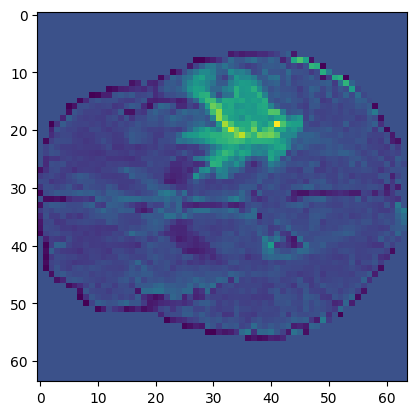

In [162]:
plt.imshow(np.load(f'./BraTS/BraTS2021_Training_Data_2D/BraTS2021_{extract_id(testing_files[img])[0]}/flair/BraTS2021_{extract_id(testing_files[img])[0]}_flair_{extract_id(testing_files[img])[1]}.npy'))

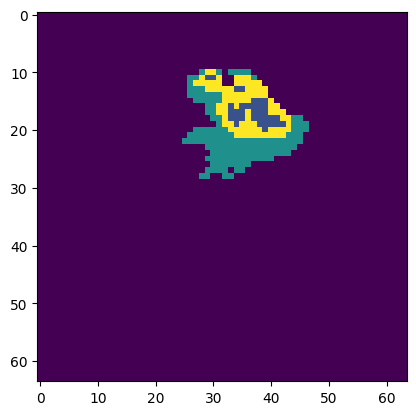

In [163]:
plt.imshow(np.load(f'./BraTS/BraTS2021_Training_Data_2D/BraTS2021_{extract_id(testing_files[img])[0]}/seg/BraTS2021_{extract_id(testing_files[img])[0]}_seg_{extract_id(testing_files[img])[1]}.npy'))

In [164]:
top_row, bottom_row, left_col, right_col = np.load(f'./BraTS/CA_Flair_Area/BraTS2021_{extract_id(testing_files[img])[0]}_ROI_pred_{extract_id(testing_files[img])[1]}.npy')

In [165]:
# resize pred
org_size = bottom_row - top_row + 1
pred_resize = cv2.resize(pred.numpy(), [org_size, org_size], interpolation=cv2.INTER_NEAREST)

In [166]:
tmp = np.zeros((64, 64))
if bottom_row - top_row == right_col - left_col:
    tmp[top_row:bottom_row+1, left_col:right_col+1] = pred_resize
elif bottom_row - top_row > right_col - left_col:
    tmp[top_row:bottom_row, left_col:right_col+1] = pred_resize
else:
    tmp[top_row:bottom_row+1, left_col:right_col] = pred_resize

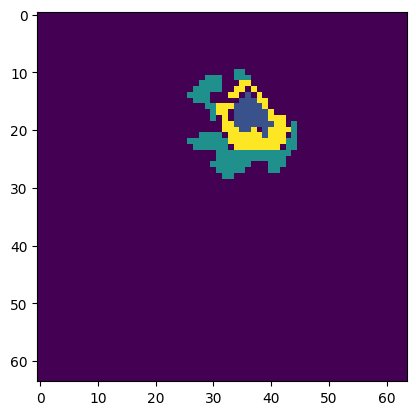

In [167]:
plt.imshow(tmp)